In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

#value iteration
#we can change this number to figure out which works best
num_theta_bins = 151
num_theta_dot_bins = 151
num_action_bins =5

#arrays for these descrite states and actions
theta_bins = np.linspace(-np.pi, np.pi, num_theta_bins, dtype=np.float32)
theta_dot_bins = np.linspace(-8, 8, num_theta_dot_bins, dtype=np.float32)
action_bins = np.linspace(-2.0, 2.0, num_action_bins, dtype=np.float32)

#hyper parameters 
gamma = 0.995
#to check the convergence, its a threshold value
epsilon = 1e-4 

V = np.zeros((num_theta_bins, num_theta_dot_bins), dtype=np.float32)
Policy = np.ones((num_theta_bins, num_theta_dot_bins), dtype= int)

#to produce angle between -pi to pi but last pi in not in it
def theta_normalize(x):
    return ((x + np.pi) % (2 * np.pi)) - np.pi

print("starting a value iteration...")
num_iterations = 0
while True:
    delta = 0
    num_iterations += 1
    V_new = np.copy(V)

    #iterate over all states
    for i in range(num_theta_bins):
        for j in range(num_theta_dot_bins):
            current_theta = theta_bins[i]
            current_theta_dot = theta_dot_bins[j]

            Q_values = np.zeros(num_action_bins)

            #iterate over all possible actions from current state
            for a_idx in range(num_action_bins):
                current_action = action_bins[a_idx]

                # --- ANALYTICAL DYNAMICS CALCULATION ---
                # Parameters from Pendulum-v1 source:
                g = 10.0 # Gravitational constant
                l = 1.0  # Length of pendulum
                m = 1.0  # Mass of pendulum
                dt = 0.05 # Time step (env.dt for Pendulum-v1)

                #lets clip the input action for safety
                current_action = np.clip(current_action, -2.0, 2.0)

                #can change it to change behaviour to optimise
                #cost = theta_normalize(current_theta) ** 2 + 0.1 * current_theta_dot ** 2 + 0.1 * current_action ** 2
                #for inverted pendulum
                cost = current_theta**2
                reward = - cost

                #approximation the simulation uses 
                new_theta_dot = current_theta_dot + ((3*g)/(2*l) * np.sin(current_theta) + 3.0 * current_action/(m * l**2)) * dt
                new_theta_dot = np.clip(new_theta_dot, -8.0, 8.0)

                new_theta = current_theta + new_theta_dot * dt
                new_theta = theta_normalize(new_theta)

                #get the discrete indices for the next state
                new_theta_idx = np.digitize(new_theta, theta_bins) - 1
                new_theta_idx = np.clip(new_theta_idx, 0, num_theta_bins - 1)

                new_theta_dot_idx = np.digitize(new_theta_dot, theta_dot_bins) - 1
                new_theta_dot_idx = np.clip(new_theta_dot_idx, 0, num_theta_dot_bins - 1)

                #bellman optimality equation:
                Q_values[a_idx] = reward + gamma * V[new_theta_idx, new_theta_dot_idx]

            best_Q_value = np.max(Q_values)
            best_action_idx = np.argmax(Q_values)

            #to track convergence
            delta = max(delta, np.abs(V_new[i, j] - best_Q_value))

            #update the value function and policy 
            V_new[i, j] = best_Q_value
            Policy[i, j] = best_action_idx
    
    #after iterating over all states, update the main policy
    V = V_new
    print(f"Iteration {num_iterations:04d}, Max Delta: {delta:.6f}")

    #check for convergence
    if delta < epsilon:
        break

print(f"\nValue Iteration converged in {num_iterations} iterations.")

starting a value iteration...
Iteration 0001, Max Delta: 9.869605
Iteration 0002, Max Delta: 9.820258
Iteration 0003, Max Delta: 9.771156
Iteration 0004, Max Delta: 9.722301
Iteration 0005, Max Delta: 9.673691
Iteration 0006, Max Delta: 9.625324
Iteration 0007, Max Delta: 9.577198
Iteration 0008, Max Delta: 9.529312
Iteration 0009, Max Delta: 9.481667
Iteration 0010, Max Delta: 9.434259
Iteration 0011, Max Delta: 9.387085
Iteration 0012, Max Delta: 9.340149
Iteration 0013, Max Delta: 9.293447
Iteration 0014, Max Delta: 9.002047
Iteration 0015, Max Delta: 8.957035
Iteration 0016, Max Delta: 8.912251
Iteration 0017, Max Delta: 8.867687
Iteration 0018, Max Delta: 8.823351
Iteration 0019, Max Delta: 8.779230
Iteration 0020, Max Delta: 8.735332
Iteration 0021, Max Delta: 8.691656
Iteration 0022, Max Delta: 8.648201
Iteration 0023, Max Delta: 8.604950
Iteration 0024, Max Delta: 8.561924
Iteration 0025, Max Delta: 8.519115
Iteration 0026, Max Delta: 8.476521
Iteration 0027, Max Delta: 8.43413

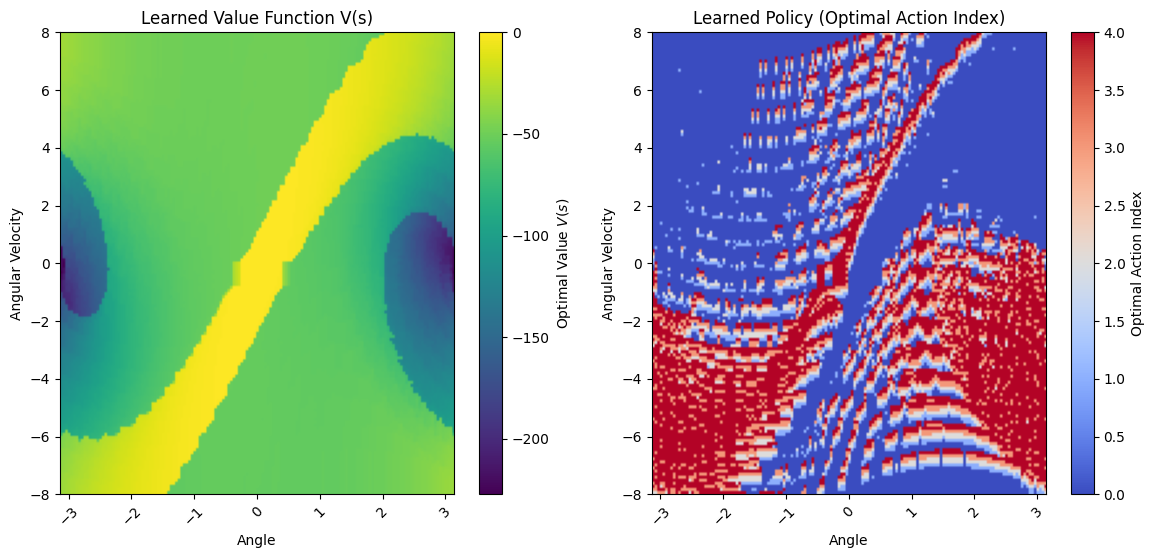

In [80]:
#ploting the value functino and policy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
plt.imshow(V.T, cmap='viridis',   #V.T because V(num_theta_bins, num_theta_dot_bins) goes to (y , x)
           extent=[theta_bins.min(), theta_bins.max(), theta_dot_bins.min(), theta_dot_bins.max()],
           aspect='auto')
plt.colorbar(label='Optimal Value $V(s)$')
plt.xlabel('Angle')
plt.ylabel('Angular Velocity') 
plt.title('Learned Value Function V(s)')
plt.xticks(rotation=45) #x axis lable rotation

plt.subplot(1, 2, 2) #1 row, 2 columns, second plot
plt.imshow(Policy.T, cmap='coolwarm',
           extent=[theta_bins.min(), theta_bins.max(), theta_dot_bins.min(), theta_dot_bins.max()],
           aspect='auto')
plt.colorbar(label='Optimal Action Index')
plt.xlabel('Angle')
plt.ylabel('Angular Velocity')
plt.title('Learned Policy (Optimal Action Index)')
plt.xticks(rotation=45)

plt.show()

In [ ]:
# Save the learned policy and value function
policy_filename = 'pendulum_policy_and_value.pkl'
with open(policy_filename, 'wb') as f:
    pickle.dump({'V': V, 'Policy': Policy}, f)
    
print(f"Policy and Value function saved to {policy_filename}")


Policy and Value function saved to pendulum_policy_and_value.pkl


In [84]:
import os
#open the saved policy
policy_filename = 'pendulum_policy_and_value.pkl' 

V = None
Policy = None

if os.path.exists(policy_filename):
    with open(policy_filename, 'rb') as f:
        loaded_data = pickle.load(f)
        V = loaded_data['V']
        Policy = loaded_data['Policy']
    print(f"Policy and Value function loaded from {policy_filename}")
else:
    print(f"Error: Policy file '{policy_filename}' not found. Please run the training code first.")


Policy and Value function loaded from pendulum_policy_and_value.pkl


In [85]:
#check policy is it working !!!
env = gym.make("Pendulum-v1", render_mode="human")
num_test_episodes = 3

total_rewards = []

for episode in range(num_test_episodes):
    obs, info = env.reset()
    terminated = False
    truncated = False

    episode_reward = 0

    while (not terminated and not truncated):

        #the observation = [sin(theta), cos(theta), theta_dot]
        current_theta = np.arctan2(obs[1], obs[0])
        current_theta_dot = obs[2]

        #get the discrete indices for the next state
        current_theta_idx = np.digitize(current_theta, theta_bins) - 1
        current_theta_idx = np.clip(current_theta_idx, 0, num_theta_bins - 1)

        current_theta_dot_idx = np.digitize(current_theta_dot, theta_dot_bins) - 1
        current_theta_dot_idx = np.clip(current_theta_dot_idx, 0, num_theta_dot_bins - 1)

        # Look up the optimal action from the learned policy table.
        best_action_idx = Policy[current_theta_idx, current_theta_dot_idx]
        best_action = action_bins[best_action_idx]

        # Take the step
        new_obs, reward, terminated, truncated, info = env.step(np.array([best_action]))
        
        obs = new_obs
        episode_reward += reward

        if terminated or truncated:
            break

    total_rewards.append(episode_reward)
    print(f"Episode {episode + 1}: Total Reward = {episode_reward:.2f}")

env.close()

Episode 1: Total Reward = -1035.73
Episode 2: Total Reward = -114.85
Episode 3: Total Reward = -121.54
